# Problem Solution Using LSTM .... by LIPIKA SHARMA

## Data Preprocessing

In [58]:
# Import necessary libraries

In [59]:
!pip install tensorflow

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
# Load the data
data = pd.read_csv('Dispense.csv')
data.head()

,Account,ATMID,caldate,Dispense,DT,MaxCapacity,CountTotalTxn
0,ABC,SPCN02020,01-01-2021,564500,0,2640000,157
1,ABC,TPCN10269,01-01-2021,509000,9,3520000,92
2,ABC,APCN00816,01-01-2021,64800,0,2640000,36
3,PQR,S1CN1142,01-01-2021,834500,0,3520000,101
4,PQR,S1CN2022,01-01-2021,825700,0,2860000,364


In [62]:
# Convert caldate to datetime
data['caldate'] = pd.to_datetime(data['caldate'], format='%d-%m-%Y')
data = data.sort_values(by=['ATMID', 'caldate'])

## Exploratory Data Analysis (EDA)

In [63]:
# Summary statistics
data.describe()

,caldate,Dispense,DT,MaxCapacity,CountTotalTxn
count,14593,1.459300e+04,14593.000000,1.459300e+04,14593.000000
mean,2022-02-24 13:07:26.762146304,4.027993e+05,158.538614,3.279753e+06,105.322963
min,2021-01-01 00:00:00,0.000000e+00,0.000000,2.420000e+06,0.000000
25%,2021-08-28 00:00:00,1.685000e+05,0.000000,2.860000e+06,45.000000
50%,2022-03-07 00:00:00,3.653000e+05,0.000000,3.520000e+06,98.000000
75%,2022-09-02 00:00:00,5.780000e+05,64.000000,3.520000e+06,146.000000
max,2023-02-22 00:00:00,2.151800e+06,1440.000000,3.740000e+06,561.000000
std,NaN,3.036762e+05,356.073765,3.974770e+05,76.727151


In [66]:
# Handle missing values
data.ffill(inplace=True)

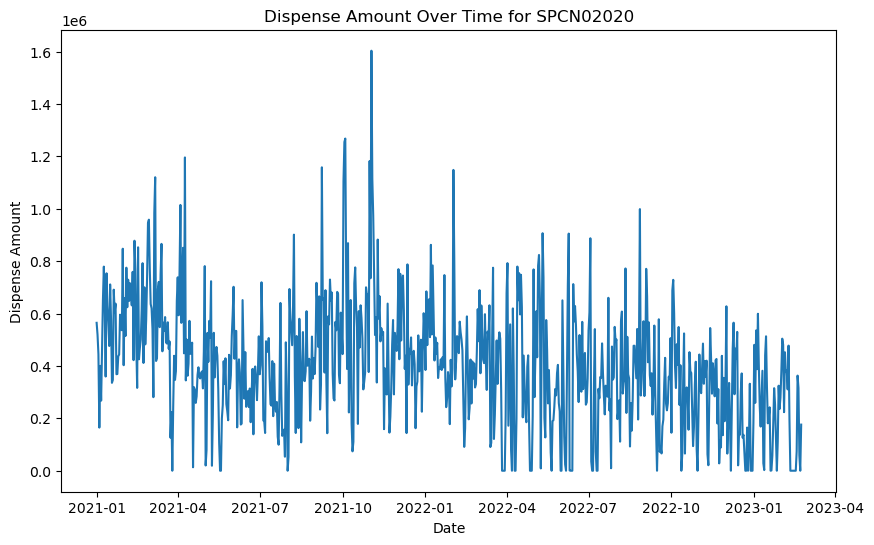

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dispense amount over time for a sample ATM
sample_atm = data[data['ATMID'] == 'SPCN02020']
plt.figure(figsize=(10, 6))
plt.plot(sample_atm['caldate'], sample_atm['Dispense'])
plt.title('Dispense Amount Over Time for SPCN02020')
plt.xlabel('Date')
plt.ylabel('Dispense Amount')
plt.show()

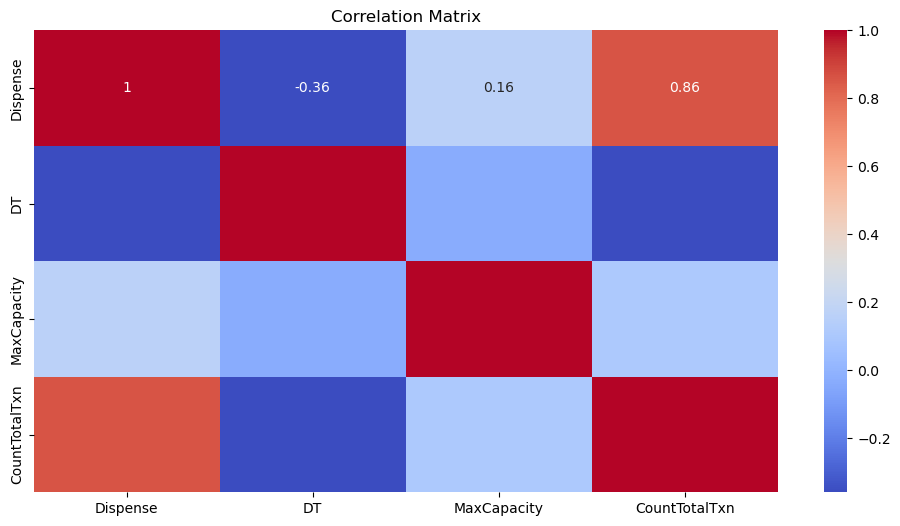

In [68]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## # Feature Engineering

In [69]:
def create_features(df):
    df['year'] = df['caldate'].dt.year
    df['month'] = df['caldate'].dt.month
    df['day'] = df['caldate'].dt.day
    df['weekday'] = df['caldate'].dt.weekday
    return df

data = create_features(data)

# Normalize the dispense amount
scaler = StandardScaler()
data['Dispense_scaled'] = scaler.fit_transform(data[['Dispense']])

## Model Selection and Training (LSTM Approach)

In [70]:
# Creating sequences for LSTM
def create_sequences(df, seq_length):
    sequences = []
    for i in range(len(df) - seq_length):
        sequence = df['Dispense_scaled'].values[i:i+seq_length]
        label = df['Dispense_scaled'].values[i+seq_length]
        sequences.append((sequence, label))
    return sequences

seq_length = 30  # Using the past 30 days to predict the next day
atm_sequences = {}

for atm_id in data['ATMID'].unique():
    atm_data = data[data['ATMID'] == atm_id]
    atm_sequences[atm_id] = create_sequences(atm_data, seq_length)

# Preparing the data for LSTM
X, y = [], []
for atm_id in atm_sequences:
    atm_X, atm_y = zip(*atm_sequences[atm_id])
    X.extend(atm_X)
    y.extend(atm_y)

X = np.array(X)
y = np.array(y)

In [71]:
# Split into train and test sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape input to be 3D for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

D:\New folder\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f'Mean Squared Error: {mse}')

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.5938 - val_loss: 0.3643
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.5053 - val_loss: 0.3531
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.4685 - val_loss: 0.3384
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.4781 - val_loss: 0.3365
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.4486 - val_loss: 0.3303
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.4596 - val_loss: 0.3371
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.4813 - val_loss: 0.3304
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.4771 - val_loss: 0.3401
Epoch 9/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.4696 - val_loss: 0.3382
Epoch 10/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.4565 - val_loss: 0.3333
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Mean Squared Error: 60678255268.89817


## Visualization

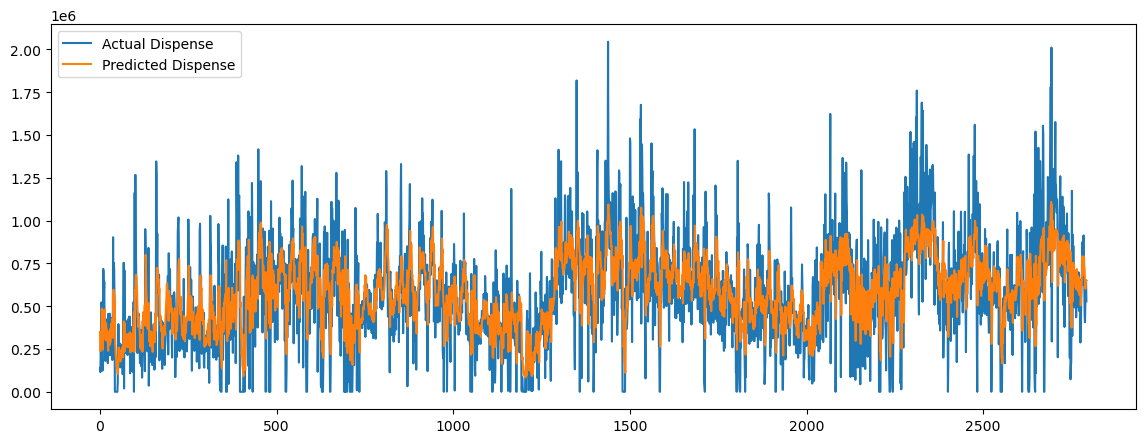

In [73]:
# Visualization of actual vs predicted
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='Actual Dispense')
plt.plot(y_pred_inv, label='Predicted Dispense')
plt.legend()
plt.show()

## Forecasting

In [75]:
# Forecasting next 7 days
def forecast_next_days(model, data, seq_length, n_days):
    forecasts = []
    input_seq = data.reshape((1, seq_length, 1))  # Reshape to match the input format of the model
    for _ in range(n_days):
        next_dispense = model.predict(input_seq)
        next_dispense = next_dispense.reshape((1, 1, 1))  # Reshape next_dispense to match the dimensions
        forecasts.append(next_dispense[0, 0, 0])
        input_seq = np.append(input_seq[:, 1:, :], next_dispense, axis=1)
    return forecasts

# Forecast for each ATM
forecast_results = {}
for atm_id in data['ATMID'].unique():
    atm_data = data[data['ATMID'] == atm_id]
    atm_seq = atm_data['Dispense_scaled'].values[-seq_length:]
    forecast = forecast_next_days(model, atm_seq, seq_length, 7)
    forecast_inv = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    forecast_results[atm_id] = forecast_inv

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [76]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [77]:
# Assuming `data` is your DataFrame and `model` is your trained model

# Define forecast_next_days function
def forecast_next_days(model, atm_seq, seq_length, forecast_days):
    # Dummy implementation for illustration; replace with your actual function
    return [0.5] * forecast_days

# Initialize and fit the MinMaxScaler on the original 'Dispense_scaled' column
scaler = MinMaxScaler()
scaler.fit(data['Dispense_scaled'].values.reshape(-1, 1))

# Length of the sequence used for prediction
seq_length = 30

In [78]:
# Forecast for each ATM
forecast_results = {}
for atm_id in data['ATMID'].unique():
    atm_data = data[data['ATMID'] == atm_id]
    
    # Ensure there are enough data points to form a sequence
    if len(atm_data) >= seq_length:
        atm_seq = atm_data['Dispense_scaled'].values[-seq_length:]
        
        # Check the shape of atm_seq
        if atm_seq.shape[0] == seq_length:
            forecast = forecast_next_days(model, atm_seq, seq_length, 7)
            
            # Ensure forecast is a numpy array
            forecast = np.array(forecast).reshape(-1, 1)
            
            # Check if forecast can be inverse transformed
            if forecast.shape[1] == 1:
                forecast_inv = scaler.inverse_transform(forecast)
                forecast_results[atm_id] = forecast_inv
            else:
                print(f"Error: Forecast shape {forecast.shape} is not suitable for inverse transform")
        else:
            print(f"Error: ATM {atm_id} sequence length {atm_seq.shape[0]} does not match {seq_length}")
    else:
        print(f"Error: Not enough data for ATM {atm_id}")

# Check the forecast results
print(forecast_results)

{'APAN11109': array([[2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416]]), 'APAN22403': array([[2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416]]), 'APAN23217': array([[2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416]]), 'APAN35706': array([[2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416]]), 'APCN00816': array([[2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416]]), 'S1CN1142': array([[2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416],
       [2.21658416]]), 'S1CN2011': array([[2.216584

## Save the Final Result

In [79]:
import numpy as np
import pandas as pd

# Assuming forecast_results is a dictionary with ATM IDs as keys and 2D forecast arrays as values
flattened_results = {atm_id: forecast.flatten() for atm_id, forecast in forecast_results.items()}

# Convert the flattened results dictionary to a DataFrame
forecast_df = pd.DataFrame.from_dict(flattened_results, orient='index')
forecast_df.columns = [f'Day_{i+1}' for i in range(forecast_df.shape[1])]

# Save the DataFrame to a CSV file
forecast_df.to_csv('atm_dispense_forecasts.csv', index=True)

# Save the Jupyter Notebook and Python script
# (In Jupyter Notebook, use the following code to save the notebook)
# !jupyter nbconvert --to script atm_dispense_forecast.ipynb

# Save the model in the native Keras format
model.save('atm_dispense_model.keras')